<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Exercise 3 | Invariance

In both of the following exercises, your goal will be to implement the following algorithm (the only difference between the two exercises is the `pre` operator):
$$
\begin{array}{l}
% \textbf{Input:}  \mathcal{X} \\
% \textbf{Output:}  \mathcal{O}_{\infty} \\
	\Omega_0 \gets \mathcal{X} \\
	\textbf{loop} \\
	\quad \Omega_{i+1} \gets \text{pre}(\Omega_i) \cap \Omega_i \\
	\quad \textbf{if} ~ \Omega_{i+1} == \text{pre} (\Omega_i) \\
	\quad\quad \textbf{return} ~\mathcal{O}_{\infty} = \Omega_i \\
	\quad \textbf{end if} \\
	 \textbf{end loop}
\end{array}
$$
<!-- $$
\begin{array}{l}
\textbf{Input:}  \mathcal{X} \\
\textbf{Output:}  \mathcal{O}_{\infty} \\
	\quad \Omega_0 \gets \mathcal{X} \\
	\quad \textbf{loop} \\
	\quad\quad \Omega_{i+1} \gets pre \Omega_i \cap \Omega_i \\
	\quad\quad \textbf{if} ~ \Omega_{i+1} == \textbf{pre} \Omega_i \\
	\quad\quad\quad \textbf{return} \mathcal{O}_{\infty} = \Omega_i \\
	\quad\quad \textbf{end if} \\
	\quad \textbf{end loop}
\end{array}
$$ -->


**Some Python implementation hints**:
- The function `P = Polyhedron.from_Hrep(H, h)` creates the polyhedron $\{x \mid Hx \leq h \}$

- Given two polytopes P1 and P2, the operator `P1 == P2` returns True if the polytopes are the same, and False otherwise

- Given a polytope P, `A = P.A` and `b = P.b` returns $A$ and $b$ such that $P = \{ x \mid Ax \leq b \}$

- To plot a polytope P, use `P.plot(ax)` where `ax` is an instance of `matplotlib.axes.Axes`

- The function projection computes the projection of a polytope: 
	$$ P = \left\{ (x, y) \in \mathbb{R}^n \times \mathbb{R}^m ~ \mid ~ H \begin{bmatrix} x \\ y \end{bmatrix} \leq b \right\} $$
	The projection of P onto x is:
	$$ P_x = \left\{ x ~ \mid ~ \exists y  \text{ s.t. } (x, y) \in P \right\} = \{ x \mid E x \leq e \} $$
- The projection $P_x$ can be computed with: `Px = P.projection(dims)`, where `dims` is an array containing the indices of dimension you want to project onto.

- The feedback matrix $K$ in $u=-Kx$ of LQR controller can be computed using the `dlqr` function in Python Control Toolbox: `from control import dlqr; K, _, _ = dlqr(A, B, Q, R)`.



## Problem 1 | Compute Invariant Sets

Consider the discrete-time linear time-invariant system defined by

$$
x^+ = Ax
$$

with

$$
A = 
\begin{bmatrix}
\cos \alpha & \sin \alpha \\
- \sin \alpha & \cos \alpha
\end{bmatrix} \beta, \quad \alpha = \frac{\pi}{6}, \quad \beta = 0.8,
$$

and state constraint set

$$
\mathcal{X} = \{ x \mid Hx \leq h \}, \quad
H =
\begin{bmatrix}
\cos\gamma & \sin\gamma \\
- \cos\gamma & - \sin\gamma \\
\sin\gamma & - \cos\gamma \\
- \sin\gamma & \cos\gamma
\end{bmatrix}, \quad \gamma = \frac{\pi}{3}, \quad
h =
\begin{bmatrix}
2 \\
1 \\
2 \\
5
\end{bmatrix}.
$$



In [2]:
import numpy as np
from mpt4py import Polyhedron

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

alpha = np.pi/6
beta = 0.8
gamma = np.pi/3

A = beta * np.array([
    [np.cos(alpha), np.sin(alpha)], 
    [-np.sin(alpha), np.cos(alpha)]
    ])
H = np.array([
    [np.cos(gamma), np.sin(gamma)],
    [-np.cos(gamma), -np.sin(gamma)],
    [np.sin(gamma), -np.cos(gamma)],
    [-np.sin(gamma), np.cos(gamma)]
])
h = np.array([2., 1., 2., 5.])
X = Polyhedron.from_Hrep(H, h)  # state constraints

### Task 1
Compute the largest invariant set $\mathcal{O}_\infty$ of the constrained system such that $\mathcal{O}_\infty \subseteq \mathcal{X}$. Plot $\mathcal{X}$ and $\mathcal{O}_\infty $ 


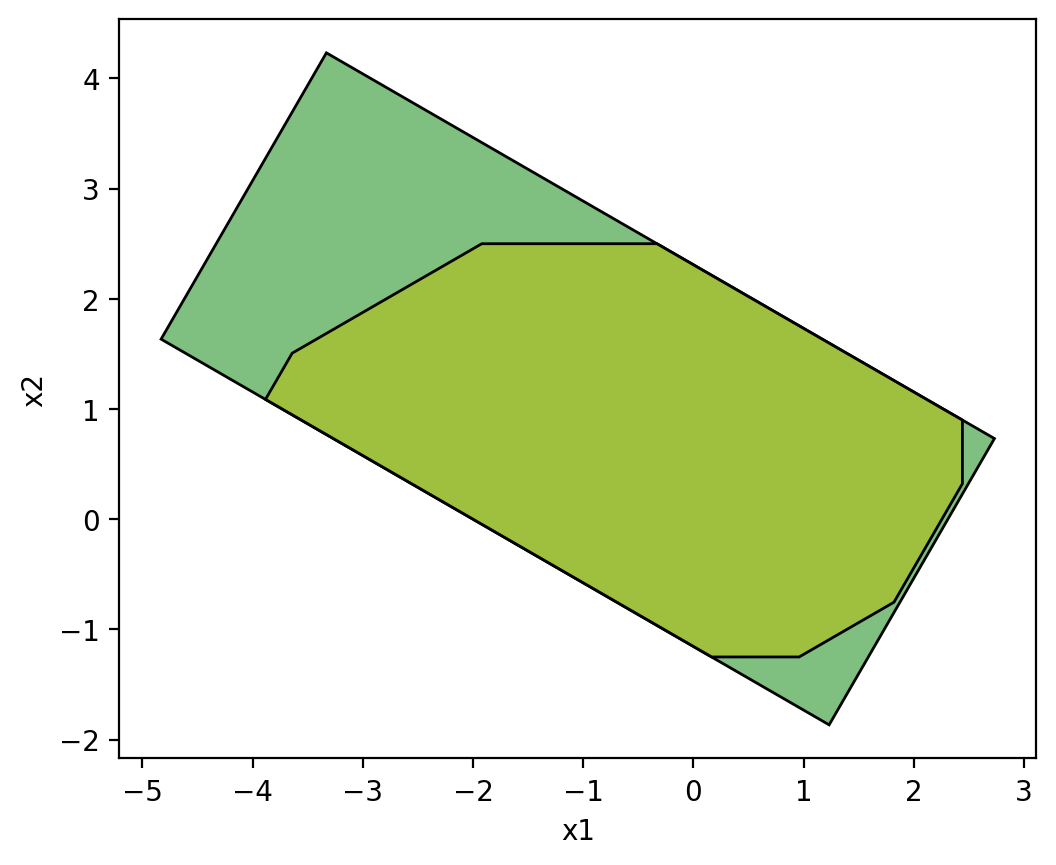

In [16]:
# Compute the maximum invariant set
def max_invariant_set(A_cl: np.ndarray, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	
	prev = X
	i = 0
	while i < max_iter:
		next = Polyhedron.from_Hrep(prev.A @ A_cl, prev.b).intersect(prev)
		if next == prev:
			return next
		else:
			prev = next
			i += 1
	print('Max iterations reached')
	return next


# Compute max invariant set
O_inf = max_invariant_set(A, X)

# Visualization
fig, ax = plt.subplots(1, 1)
X.plot(ax, color='g', opacity=0.5, show_vertices=False)
O_inf.plot(ax, color='y', opacity=0.5, show_vertices=False)
ax.set_aspect('equal')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

### Task 2
Plot several trajectories starting from various states within $\mathcal{O}_\infty $. Show that the entire trajectory $\{x_i\}$ remains within $\mathcal{O}_\infty$.

**Hints:** in *mpt4py*, you can uniformly sample $m$ points from a polyhedron $P\subset \mathbb{R}^n$ with `x_sampled = P.sample(m)`, where `x_sample` is a NumPy array with shape `(m, n)`.


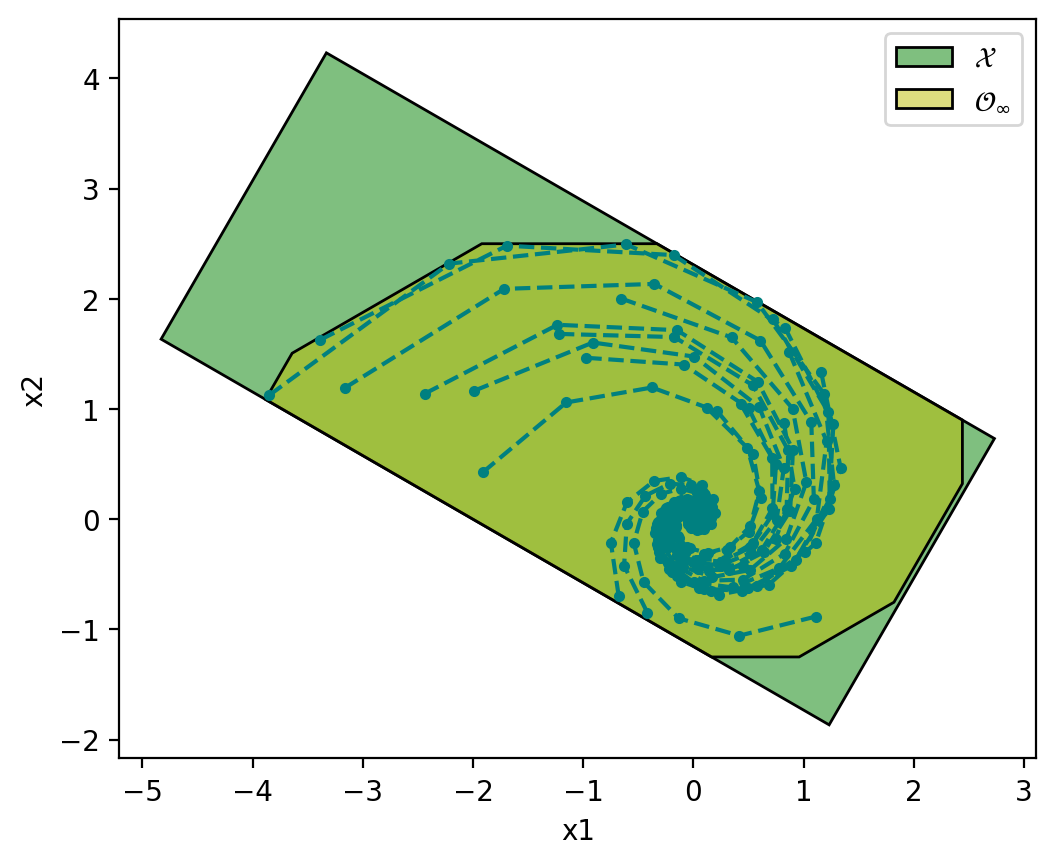

In [25]:
num_samples = 20
x0_samples = O_inf.sample(num_samples)  # ndarray with shape (num_samples, 2)
N_sim = 50  # simulation steps


# Plot the sets
fig, ax = plt.subplots(1, 1)
X.plot(ax, color='g', opacity=0.5, label=r'$\mathcal{X}$')
O_inf.plot(ax, color='y', opacity=0.5, label=r'$\mathcal{O}_\infty$')
ax.set_aspect('equal')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

trajectories = np.zeros(shape=(N_sim + 1, 2, num_samples))
trajectories[0] = x0_samples.T
for i in range(N_sim):
    trajectories[i + 1] = A @ trajectories[i]

for i in range(num_samples):
    plt.plot(trajectories[:, 0, i], trajectories[:, 1, i], linestyle='--', color='teal', marker='.')

ax.legend()
plt.show()

### Task 3
Plot several trajectories $\{x_0, ..., x_N\}$ where $x_0 \in \mathcal{X} \setminus \mathcal{O}_\infty $. Show that there exists an $x_i \notin \mathcal{X}$.

**Hints:** You can sample points $x_0\in \mathcal{X}\setminus \mathcal{O}_\infty$ by sampling a number of points from $\mathcal{X}$ and remove those that aren't in the $\mathcal{O}_\infty$.

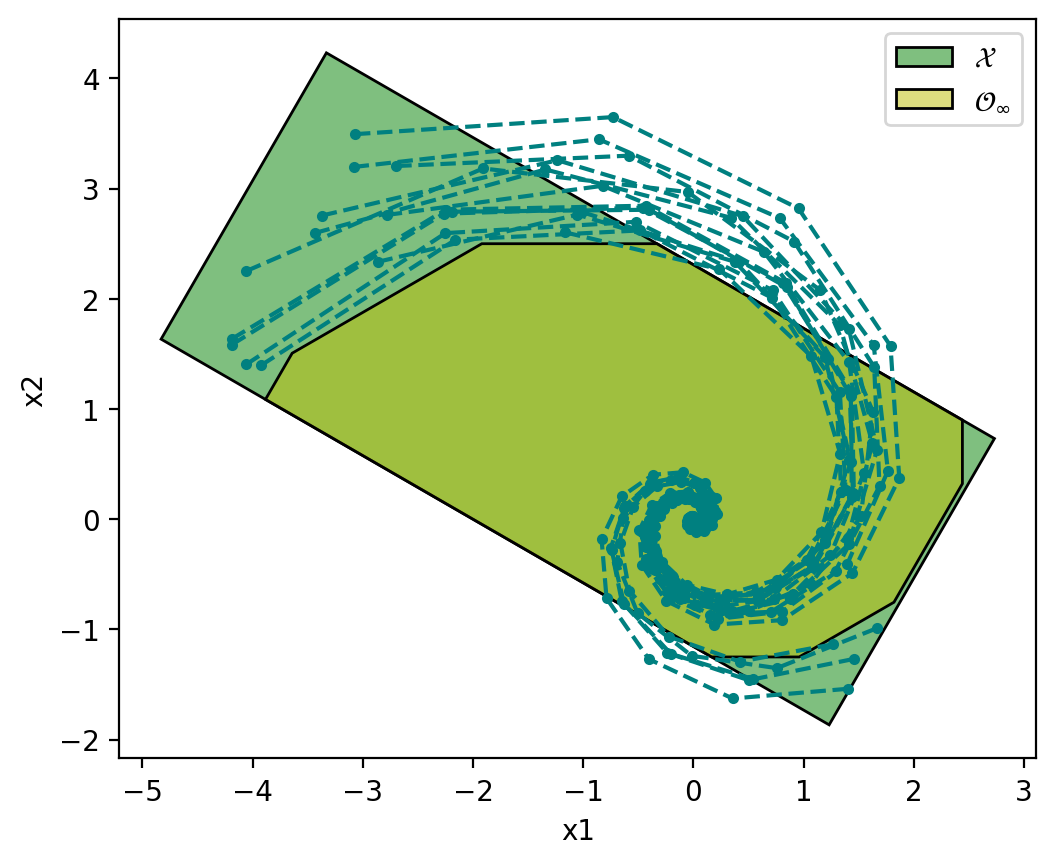

In [27]:
N_sim = 50  # simulation steps

# Plot the sets
fig, ax = plt.subplots(1, 1)
X.plot(ax, color='g', opacity=0.5, label=r'$\mathcal{X}$')
O_inf.plot(ax, color='y', opacity=0.5, label=r'$\mathcal{O}_\infty$')
ax.set_aspect('equal')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# Sample x0 in X but not in O_inf

def sample_outside() -> np.ndarray:
    s_i = 0
    samples = np.zeros(shape=(num_samples, 2))
    while True:
        batch = X.sample(num_samples)
        for element in batch:
            if not O_inf.contains(element):
                samples[s_i] = element
                s_i += 1
                if s_i == num_samples:
                    return samples

# Compute trajectories and plot
trajectories = np.zeros(shape=(N_sim + 1, 2, num_samples))
trajectories[0] = sample_outside().T
for i in range(N_sim):
    trajectories[i + 1] = A @ trajectories[i]

for i in range(num_samples):
    plt.plot(trajectories[:, 0, i], trajectories[:, 1, i], linestyle='--', color='teal', marker='.')

ax.legend()
plt.show()

## Problem 2 | Compute Controlled Invariant Sets

Consider the discrete-time LTI system defined by:

$$
x^+ = Ax + Bu,
$$

with:

$$
A = \beta 
\begin{bmatrix}
\cos\alpha & \sin\alpha \\
-\sin\alpha & \cos\alpha
\end{bmatrix}, \quad 
\alpha = \frac{\pi}{6}, \quad 
\beta = 0.8, \quad 
B = \begin{bmatrix} 0.5 \\ 0.5 \end{bmatrix},
$$

and state and input constraints $(x, u) \in \mathcal{X} \times \mathcal{U}$:
$$
\mathcal{X} = \{ x \mid Hx \leq h \}, \quad 
H = 
\begin{bmatrix}
\cos(\pi/3) & \sin(\pi/3) \\
- \cos(\pi/3) & - \sin(\pi/3) \\
\sin(\pi/3) & - \cos(\pi/3) \\
- \sin(\pi/3) & \cos(\pi/3)
\end{bmatrix}, \quad 
h = \begin{bmatrix} 2 \\ 1 \\ 2 \\ 5 \end{bmatrix}, \quad

\mathcal{U} = \{ u \mid -0.5 \leq u \leq 0.5 \}
$$


In [29]:
# Define the system components
alpha = np.pi/6
beta = 0.8
gamma = np.pi/3

A = beta * np.array([
    [np.cos(alpha), np.sin(alpha)], 
    [-np.sin(alpha), np.cos(alpha)]
    ])
B = np.array([[0.5], [0.5]])

H = np.array([
    [np.cos(gamma), np.sin(gamma)],
    [-np.cos(gamma), -np.sin(gamma)],
    [np.sin(gamma), -np.cos(gamma)],
    [-np.sin(gamma), np.cos(gamma)]
])
h = np.array([2., 1., 2., 5.])

X = Polyhedron.from_Hrep(H, h)
U = Polyhedron.from_Hrep(np.array([[1], [-1]]), np.array([0.5, 0.5]))

### Task 1 

Compute the maximum controlled invariant set $ \mathcal{C}_\infty $ of the constrained system such that $ \mathcal{C}_\infty \subseteq \mathcal{X} $. 

Plot $\mathcal{X}$ and $\mathcal{C}_\infty$.

<!-- **Hints**:
to compute the maximal controlled invariant set, the $\text{pre}(\cdot)$ operator can be computed in the following way:
$$
\begin{aligned}
\operatorname{pre}(S) &=\{x\mid\exists u\in\mathcal{U},\ Ax+Bu\in S\}\\
&=\{x\mid\exists u\in\mathcal{U},\ FAx+FBu\leq f\}\\
&=\left\{x\mid\exists u,\left[\begin{array}{cc}FA&FB\\0 &G\end{array}\right]\left[\begin{array}{l}x\\u\end{array}\right]\leq\left[\begin{array}{l}f\\g\end{array}\right]\right\}.
\end{aligned}
$$ -->

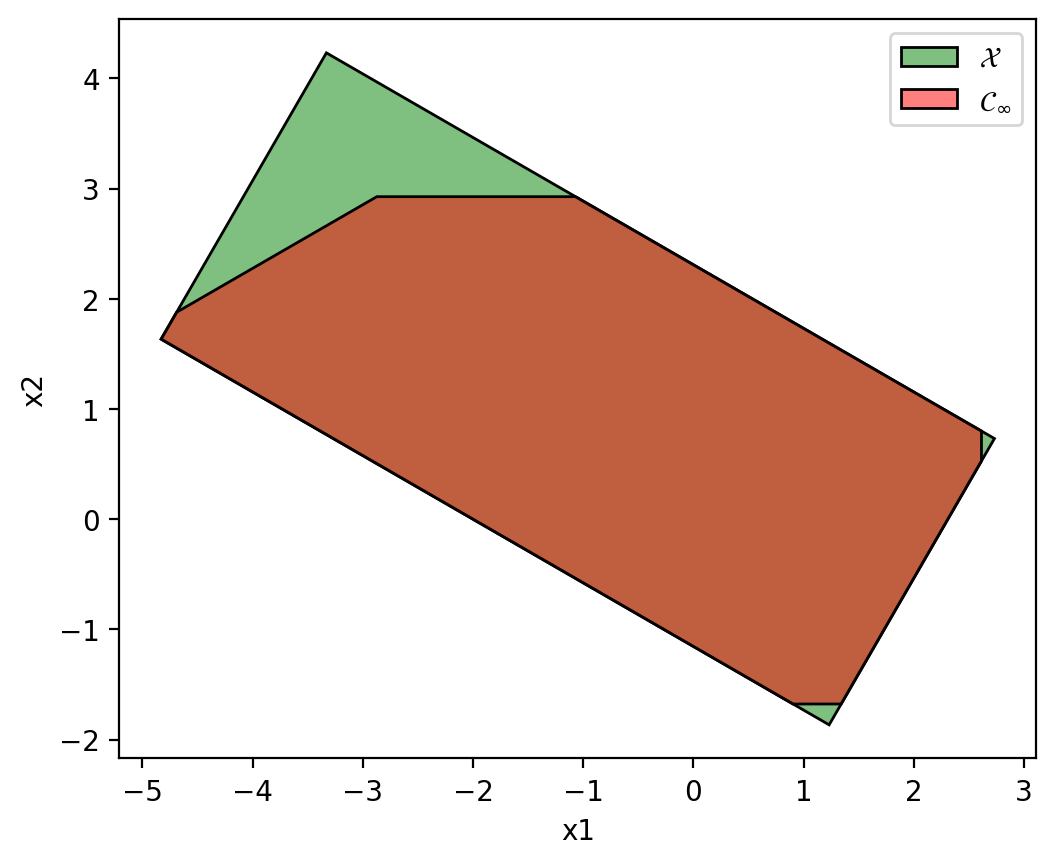

In [34]:
# Compute maximal control invariant set
def max_control_invariant_set(A: np.ndarray, B: np.ndarray, X: Polyhedron, U: Polyhedron, max_iter: int = 30) -> Polyhedron:
	"""
	Comptute the maximal control invariant set for a system x^+ = Ax + Bu, 
	with polytopic state constraints X and input constraints U.
	"""
	
	prev = X
	i = 0
	while i < max_iter:

		FA = prev.A @ A
		FB = prev.A @ B
		H = np.vstack([np.hstack([FA, FB]), np.hstack([np.zeros(shape=(U.A.shape[0], FA.shape[1])), U.A])])
		h = np.hstack([prev.b, U.b])
		next = Polyhedron.from_Hrep(H, h).projection(range(2)).intersect(prev)

		if next == prev:
			return next
		else:
			prev = next
			i += 1
	print('Max iterations reached')
	return next

# Compute the max control invariant set
C_inf = max_control_invariant_set(A, B, X, U)


# Visualization
fig, ax = plt.subplots(1,1)

X.plot(ax, color='g', opacity=0.5, label=r'$\mathcal{X}$')
C_inf.plot(ax, color='r', opacity=0.5, label=r'$\mathcal{C}_\infty$')

ax.set_aspect('equal')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.legend()
plt.show()

### Task 2

Compute the optimal LQR controller $K$ for $Q = I, R = 1 $. Define the stable system $x^+ = (A + BK)x$, with constraints $ x \in \mathcal{X} \cap K \mathcal{U} $, and compute its maximum invariant set $ \mathcal{O}_\infty $. 
  
Plot $\mathcal{O}_\infty$ on the same figure with $\mathcal{C}_\infty$ and compare the two sets. Which one would you expect to be bigger? Why?

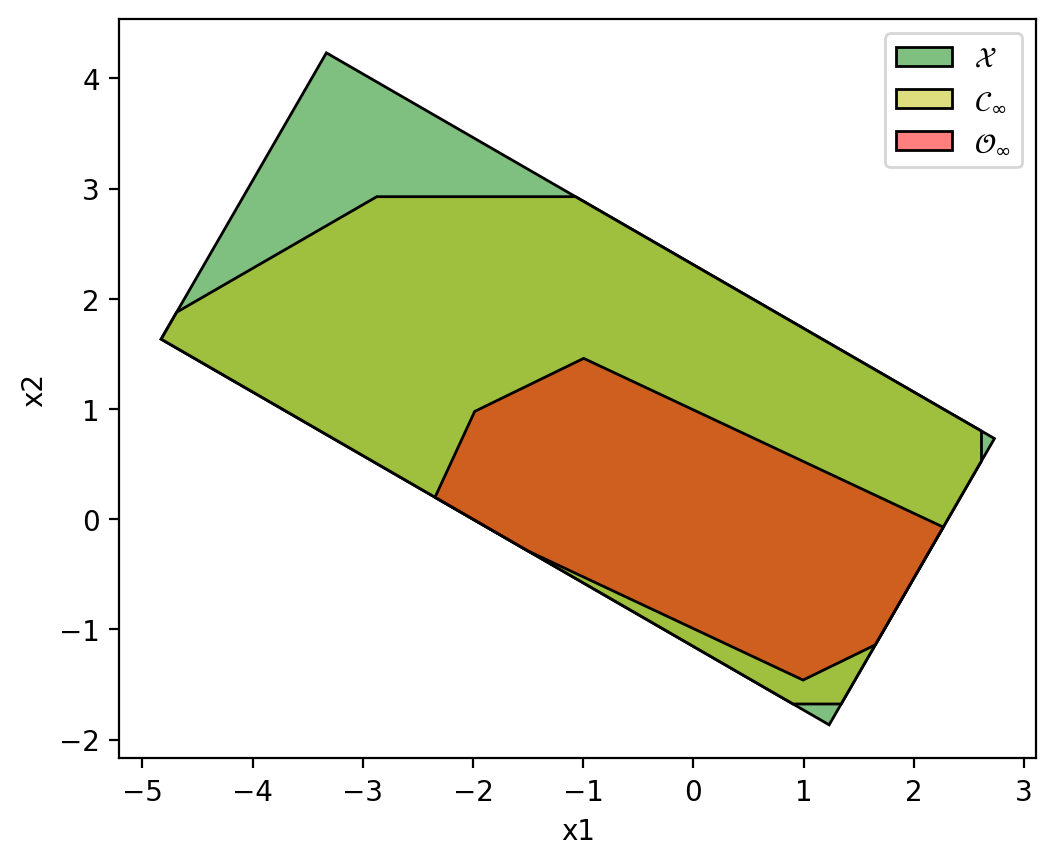

In [40]:
import control as ct

# Compute LQR gain
Q = np.eye(2)
R = 1
K, _, _ = ct.dlqr(A, B, Q, R)

# Compute max invariant set for LQR
A_cl = A + B @ -K
KU = Polyhedron.from_Hrep(U.A @ K, U.b)
O_inf = max_invariant_set(A_cl, X.intersect(KU))

# Visualization
fig, ax = plt.subplots(1,1)

X.plot(ax, color='g', opacity=0.5, label=r'$\mathcal{X}$')
C_inf.plot(ax, color='y', opacity=0.5, label=r'$\mathcal{C}_\infty$')
O_inf.plot(ax, color='r', opacity=0.5, label=r'$\mathcal{O}_\infty$')

ax.set_aspect('equal')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.legend()
plt.show()